<a href="https://colab.research.google.com/github/YanaAbakumova/Neural_networks/blob/lesson_5/Lesson5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Практическое задание

<ol>
    <li>Попробуйте обучить нейронную сеть LSTM на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). Опишите, какой результата вы получили? Что помогло вам улучшить ее точность?

    
<li>*Попробуйте на numpy реализовать нейронную сеть архитектуры LSTM</li>
<li>*Предложите свои варианты решения проблемы исчезающего градиента в RNN</li>
</ol>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow.keras as keras
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

In [ ]:
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
airlines= pd.read_csv('/content/drive/MyDrive/airline-passengers.csv')

In [236]:
airlines.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
airlines.shape

(144, 2)

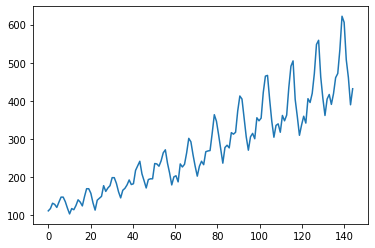

In [ ]:
plt.plot(np.linspace(0, 144, 144), airlines['Passengers'])

In [315]:
values = airlines['Passengers'].values

In [316]:
#train_split = int(len(values)*0.7)
scaler = StandardScaler()
data_v = scaler.fit_transform(values.reshape(-1, 1))
data_f = pd.DataFrame(data_v)

In [351]:
# список признаков, по которым будем учить
channelIndexes = [0]

# длина теста
valLen = int(data_f.shape[0]*0.3)
# длина истории для работы
xLen = 8
# отступ тестов от тренировок
bias = 1

# вычисляем точку разделения ряда на тесты и тренировку
train_split = data_f.shape[0] - valLen - bias
# делим
train_data = data_f.iloc[0 : train_split ,channelIndexes]
val_data = data_f.iloc[train_split+bias:,channelIndexes]
print(f' train_data.shape {train_data.shape}')
print(f' val_data.shape {val_data.shape}')

 train_data.shape (100, 1)
 val_data.shape (43, 1)


In [352]:
# шаг по данным для построения обучающих примеров
step = 1

# длина прошлого 
past = xLen
p = past
# горизонт предсказания
future = 1
h=future

# параметры модели для обучения
learning_rate = 0.001
batch_size = 1
epochs = 10

In [353]:
Chanel_numb = len(channelIndexes)

xTrain_df = train_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xTrain = xTrain_df[[train_data.columns[i] for i in range(Chanel_numb)]].values
yTrain = train_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

sequence_length = int(xLen / step)


x_end = len(val_data) - xLen - future 

label_start = len(train_data)+bias+xLen + future +1

xVal_df = val_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xVal = xVal_df[[val_data.columns[i] for i in range(Chanel_numb)]].values
yVal = val_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)


In [354]:
yVal.shape

(35,)

In [355]:
yTrain.shape

(92,)

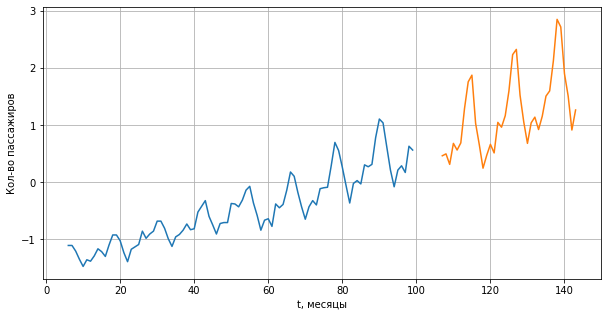

In [345]:
plt.figure(figsize=(10,5))
plt.plot(data_f.index[xLen:yTrain.shape[0]+xLen],yTrain[:])
plt.plot(data_f.index[yTrain.shape[0]+bias+future+2*xLen-1:],yVal[:])
plt.grid('on')
plt.xlabel('t, месяцы')
plt.ylabel('Кол-во пассажиров')
plt.show()

In [356]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    xTrain,
    yTrain,
    sequence_length=10,
    sampling_rate=1,
    batch_size=28,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    xVal,
    yVal,
    sequence_length=10,
    sampling_rate=1,
    batch_size=26,
)


In [357]:
for batch in dataset_val.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (26, 10, 1)
Target shape: (26,)


In [358]:
for batch in dataset_train.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (28, 10, 1)
Target shape: (28,)


In [383]:
#модель с loss = mse, optimizer=adam, epochs=85
callbaсk = EarlyStopping(monitor='val_mae', patience=5)

model = Sequential()

model.add(LSTM(128, input_shape = (inputs.shape[1], inputs.shape[2]), dropout=0.2, recurrent_dropout=0.2, return_sequences="True"))
model.add(Conv1D(128, 5, activation="linear")) #(None,3,64)
model.add(Conv1D(64, 3, activation="linear"))
model.add(Conv1D(32, 3, activation="linear"))
model.add(Conv1D(16, 1, activation="linear"))
model.add(Flatten())                          # (None, 3*64)
model.add(Dense(512, activation="linear"))  
model.add(Dense(128, activation="linear"))    
model.add(Dense(32, activation="linear"))  # (None,3)
model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=85,
    validation_data=dataset_val)

Epoch 1/85
3/3 [==============================] - 3s 234ms/step - loss: 0.6742 - mae: 0.6857 - val_loss: 0.5567 - val_mae: 0.5763
Epoch 2/85
3/3 [==============================] - 0s 71ms/step - loss: 0.0856 - mae: 0.2347 - val_loss: 2.9291 - val_mae: 1.6504
Epoch 3/85
3/3 [==============================] - 0s 74ms/step - loss: 1.3911 - mae: 1.0467 - val_loss: 3.6072 - val_mae: 1.5711
Epoch 4/85
3/3 [==============================] - 0s 75ms/step - loss: 2.9313 - mae: 1.2650 - val_loss: 1.1143 - val_mae: 0.9371
Epoch 5/85
3/3 [==============================] - 0s 77ms/step - loss: 0.3631 - mae: 0.5262 - val_loss: 2.0151 - val_mae: 1.3250
Epoch 6/85
3/3 [==============================] - 0s 74ms/step - loss: 0.6602 - mae: 0.6836 - val_loss: 1.6827 - val_mae: 1.1747
Epoch 7/85
3/3 [==============================] - 0s 70ms/step - loss: 0.4139 - mae: 0.5386 - val_loss: 1.2210 - val_mae: 0.9278
Epoch 8/85
3/3 [==============================] - 0s 73ms/step - loss: 0.2255 - mae: 0.3912 - va

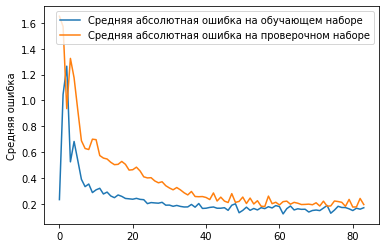

In [384]:
plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [385]:
#модель с loss = mse, optimizer=RMSProp, epochs=85
callbaсk = EarlyStopping(monitor='val_mae', patience=5)

model = Sequential()

model.add(LSTM(128, input_shape = (inputs.shape[1], inputs.shape[2]), dropout=0.2, recurrent_dropout=0.2, return_sequences="True"))
model.add(Conv1D(128, 5, activation="linear")) #(None,3,64)
model.add(Conv1D(64, 3, activation="linear"))
model.add(Conv1D(32, 3, activation="linear"))
model.add(Conv1D(16, 1, activation="linear"))
model.add(Flatten())                          # (None, 3*64)
model.add(Dense(512, activation="linear"))  
model.add(Dense(128, activation="linear"))    
model.add(Dense(32, activation="linear"))  # (None,3)
model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="RMSProp", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=85,
    validation_data=dataset_val)

Epoch 1/85
3/3 [==============================] - 4s 235ms/step - loss: 7.8468 - mae: 2.2674 - val_loss: 1.0823 - val_mae: 0.8392
Epoch 2/85
3/3 [==============================] - 0s 73ms/step - loss: 0.2458 - mae: 0.3988 - val_loss: 1.2999 - val_mae: 0.9935
Epoch 3/85
3/3 [==============================] - 0s 72ms/step - loss: 0.5900 - mae: 0.6490 - val_loss: 1.2175 - val_mae: 0.9611
Epoch 4/85
3/3 [==============================] - 0s 72ms/step - loss: 0.4656 - mae: 0.5842 - val_loss: 0.5730 - val_mae: 0.5634
Epoch 5/85
3/3 [==============================] - 0s 75ms/step - loss: 0.1925 - mae: 0.3714 - val_loss: 0.4558 - val_mae: 0.4994
Epoch 6/85
3/3 [==============================] - 0s 79ms/step - loss: 0.1139 - mae: 0.2747 - val_loss: 0.3991 - val_mae: 0.4821
Epoch 7/85
3/3 [==============================] - 0s 72ms/step - loss: 0.1012 - mae: 0.2606 - val_loss: 0.3635 - val_mae: 0.4653
Epoch 8/85
3/3 [==============================] - 0s 73ms/step - loss: 0.1311 - mae: 0.2993 - va

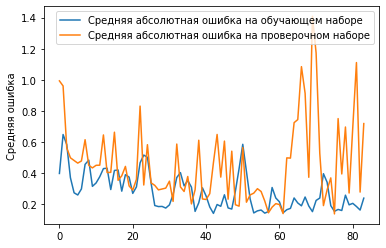

In [386]:
plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [414]:
# loss=mae, optimizer = adam, активационная функция reluб 45 эпох
callbaсk = EarlyStopping(monitor='val_mae', patience=5)

model = Sequential()

model.add(LSTM(128, input_shape = (inputs.shape[1], inputs.shape[2]), dropout=0.2, recurrent_dropout=0.2, return_sequences="True"))
model.add(Conv1D(128, 5, activation="relu")) #(None,3,64)
model.add(Conv1D(64, 3, activation="relu"))
model.add(Conv1D(32, 3, activation="relu"))
model.add(Conv1D(16, 1, activation="linear"))
model.add(Flatten())                          # (None, 3*64)
model.add(Dense(512, activation="linear"))  
model.add(Dense(128, activation="linear"))    
model.add(Dense(32, activation="linear"))  # (None,3)
model.add(Dense(1, activation="linear"))

model.compile(loss="mae", optimizer="adam", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=45,
    validation_data=dataset_val)

Epoch 1/45
3/3 [==============================] - 3s 442ms/step - loss: 0.6480 - mae: 0.6480 - val_loss: 1.1974 - val_mae: 1.1974
Epoch 2/45
3/3 [==============================] - 0s 79ms/step - loss: 0.4181 - mae: 0.4181 - val_loss: 1.1273 - val_mae: 1.1273
Epoch 3/45
3/3 [==============================] - 0s 73ms/step - loss: 0.2509 - mae: 0.2509 - val_loss: 1.0424 - val_mae: 1.0424
Epoch 4/45
3/3 [==============================] - 0s 77ms/step - loss: 0.4168 - mae: 0.4168 - val_loss: 0.9485 - val_mae: 0.9485
Epoch 5/45
3/3 [==============================] - 0s 78ms/step - loss: 0.3198 - mae: 0.3198 - val_loss: 0.7551 - val_mae: 0.7551
Epoch 6/45
3/3 [==============================] - 0s 76ms/step - loss: 0.3209 - mae: 0.3209 - val_loss: 0.7231 - val_mae: 0.7231
Epoch 7/45
3/3 [==============================] - 0s 75ms/step - loss: 0.2561 - mae: 0.2561 - val_loss: 0.7198 - val_mae: 0.7198
Epoch 8/45
3/3 [==============================] - 0s 75ms/step - loss: 0.2735 - mae: 0.2735 - va

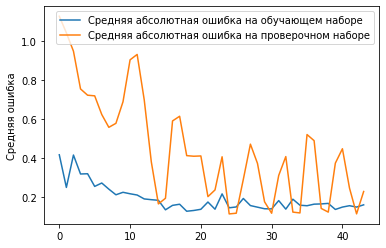

In [415]:
plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [416]:
#mae, adam, activation = linear, 50 эпох
callbaсk = EarlyStopping(monitor='val_mae', patience=5)

model = Sequential()

model.add(LSTM(128, input_shape = (inputs.shape[1], inputs.shape[2]), dropout=0.2, recurrent_dropout=0.2, return_sequences="True"))
model.add(Conv1D(128, 5, activation="linear")) #(None,3,64)
model.add(Conv1D(64, 3, activation="linear"))
model.add(Conv1D(32, 3, activation="linear"))
model.add(Conv1D(16, 1, activation="linear"))
model.add(Flatten())                          # (None, 3*64)
model.add(Dense(512, activation="linear"))  
model.add(Dense(128, activation="linear"))    
model.add(Dense(32, activation="linear"))  # (None,3)
model.add(Dense(1, activation="linear"))

model.compile(loss="mae", optimizer="adam", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=50,
    validation_data=dataset_val)

Epoch 1/50
3/3 [==============================] - 3s 242ms/step - loss: 0.5498 - mae: 0.5498 - val_loss: 1.6340 - val_mae: 1.6340
Epoch 2/50
3/3 [==============================] - 0s 73ms/step - loss: 0.8600 - mae: 0.8600 - val_loss: 0.9086 - val_mae: 0.9086
Epoch 3/50
3/3 [==============================] - 0s 74ms/step - loss: 0.6353 - mae: 0.6353 - val_loss: 1.0512 - val_mae: 1.0512
Epoch 4/50
3/3 [==============================] - 0s 77ms/step - loss: 0.5830 - mae: 0.5830 - val_loss: 1.0785 - val_mae: 1.0785
Epoch 5/50
3/3 [==============================] - 0s 70ms/step - loss: 0.5231 - mae: 0.5231 - val_loss: 0.7830 - val_mae: 0.7830
Epoch 6/50
3/3 [==============================] - 0s 76ms/step - loss: 0.3517 - mae: 0.3517 - val_loss: 0.5664 - val_mae: 0.5664
Epoch 7/50
3/3 [==============================] - 0s 71ms/step - loss: 0.3060 - mae: 0.3060 - val_loss: 0.8611 - val_mae: 0.8611
Epoch 8/50
3/3 [==============================] - 0s 70ms/step - loss: 0.4059 - mae: 0.4059 - va

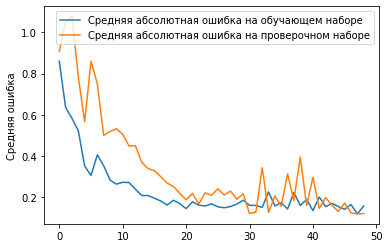

In [417]:
plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [389]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

In [390]:
len(predVal)

26

In [391]:
yVal.shape

(35,)

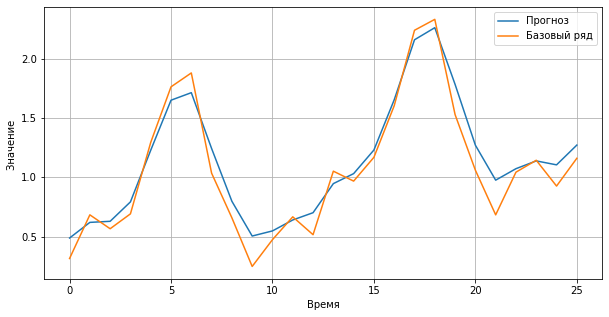

In [393]:
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal, 
         label='Прогноз')
plt.plot(yVal.flatten()[:-9], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

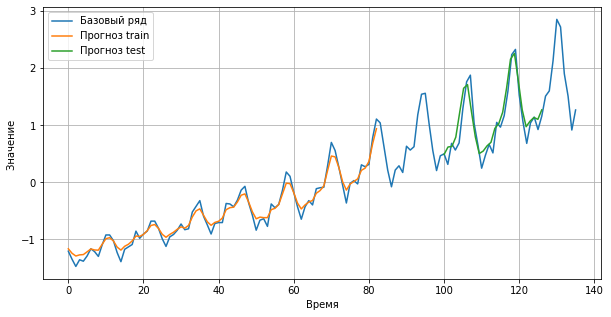

In [402]:
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(data_v.flatten()[8:], label='Базовый ряд')
plt.plot(pred, label='Прогноз train')
plt.plot(np.linspace(100, 126, 26), predVal, label='Прогноз test')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

Точность модели помогли улучшить:
- добавление сверточных слоев (больше ядер, больше размер ядра с постепенным снижением размера). Лучший результат получился на 4х слоях, дальнейшее увеличение числа слоев негативно сказалось на результате.
- добавление полносвязных слоев. Лучший результат получился на 4х слоях, дальнейшее увеличение числа слоев негативно сказалось на результате.
- подбор размера выборки (на таком маленьком наборе чем длиннее ряд, тем лучше и стабильнее результат)
- подбор оптимизатора: лучший результат дал ADAM. Пробовала RMSProp - очень высокая дисперсия ошибки, результат не стабилен. С SGD получилось, наоборот, стабильное обучение, но результат не достаточно хороший.
- подбор loss. Результат с mae лучше результата с mse. 
- с активационными фанкциями мало успела поэксперементировать, лучший результат получился при использовании только linear.

Негативно на результате сказались dropout и batchnotmalization для сверточных и полносвязных слоев

#### Реализация LSTM на numpy

In [481]:
class LSTM:
    def __init__(self, char_to_idx, idx_to_char, vocab_size, n_h=100, seq_len=25, 
                          epochs=10, lr=0.01, beta1=0.9, beta2=0.999):
        self.char_to_idx = char_to_idx # characters to indices mapping
        self.idx_to_char = idx_to_char # indices to characters mapping
        self.vocab_size = vocab_size # no. of unique characters in the training data
        self.n_h = n_h # no. of units in the hidden layer
        self.seq_len = seq_len # no. of time steps, also size of mini batch
        self.epochs = epochs # no. of training iterations
        self.lr = lr # learning rate
        self.beta1 = beta1 # 1st momentum parameter
        self.beta2 = beta2 # 2nd momentum parameter
    
        #-----initialise weights and biases-----#
        self.params = {}
        std = (1.0/np.sqrt(self.vocab_size + self.n_h)) # Xavier initialisation
        
        # forget gate
        self.params["Wf"] = np.random.randn(self.n_h, self.n_h + self.vocab_size) * std
        self.params["bf"] = np.ones((self.n_h,1))

        # input gate
        self.params["Wi"] = np.random.randn(self.n_h, self.n_h + self.vocab_size) * std
        self.params["bi"] = np.zeros((self.n_h,1))

        # cell gate
        self.params["Wc"] = np.random.randn(self.n_h, self.n_h + self.vocab_size) * std
        self.params["bc"] = np.zeros((self.n_h,1))

        # output gate
        self.params["Wo"] = np.random.randn(self.n_h, self.n_h + self.vocab_size) * std
        self.params["bo"] = np.zeros((self.n_h ,1))

        # output
        self.params["Wv"] = np.random.randn(self.vocab_size, self.n_h) * \
                                          (1.0/np.sqrt(self.vocab_size))
        self.params["bv"] = np.zeros((self.vocab_size ,1))

        #-----initialise gradients and Adam parameters-----#
        self.grads = {}
        self.adam_params = {}

        for key in self.params:
            self.grads["d"+key] = np.zeros_like(self.params[key])
            self.adam_params["m"+key] = np.zeros_like(self.params[key])
            self.adam_params["v"+key] = np.zeros_like(self.params[key])
            
        self.smooth_loss = -np.log(1.0 / self.vocab_size) * self.seq_len
        return


    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    LSTM.sigmoid = sigmoid


    def softmax(self, x):
        e_x = np.exp(x - np.max(x)) # max(x) subtracted for numerical stability
        return e_x / np.sum(e_x)

    LSTM.softmax = softmax

    def clip_grads(self):
        for key in self.grads:
            np.clip(self.grads[key], -5, 5, out=self.grads[key])
        return

    LSTM.clip_grads = clip_grads


    def reset_grads(self):
        for key in self.grads:
            self.grads[key].fill(0)
        return

    LSTM.reset_grads = reset_grads

    def update_params(self, batch_num):
        for key in self.params:
            self.adam_params["m"+key] = self.adam_params["m"+key] * self.beta1 + \
                                    (1 - self.beta1) * self.grads["d"+key]
            self.adam_params["v"+key] = self.adam_params["v"+key] * self.beta2 + \
                                    (1 - self.beta2) * self.grads["d"+key]**2
            m_correlated = self.adam_params["m" + key] / (1 - self.beta1**batch_num)
            v_correlated = self.adam_params["v" + key] / (1 - self.beta2**batch_num) 
            self.params[key] -= self.lr * m_correlated / (np.sqrt(v_correlated) + 1e-8) 
        return

    LSTM.update_params = update_params


    def forward_step(self, x, h_prev, c_prev):
        z = np.row_stack((h_prev, x))

        f = self.sigmoid(np.dot(self.params["Wf"], z) + self.params["bf"])
        i = self.sigmoid(np.dot(self.params["Wi"], z) + self.params["bi"])
        c_bar = np.tanh(np.dot(self.params["Wc"], z) + self.params["bc"])

        c = f * c_prev + i * c_bar
        o = self.sigmoid(np.dot(self.params["Wo"], z) + self.params["bo"])
        h = o * np.tanh(c)

        v = np.dot(self.params["Wv"], h) + self.params["bv"]
        y_hat = self.softmax(v)
        return y_hat, v, h, o, c, c_bar, i, f, z

    LSTM.forward_step = forward_step

    def backward_step(self, y, y_hat, dh_next, dc_next, c_prev, z, f, i, c_bar, c, o, h):
        dv = np.copy(y_hat)
        dv[y] -= 1 # yhat - y

        self.grads["dWv"] += np.dot(dv, h.T)
        self.grads["dbv"] += dv

        dh = np.dot(self.params["Wv"].T, dv)
        dh += dh_next
    
        do = dh * np.tanh(c)
        da_o = do * o*(1-o)
        self.grads["dWo"] += np.dot(da_o, z.T)
        self.grads["dbo"] += da_o

        dc = dh * o * (1-np.tanh(c)**2)
        dc += dc_next

        dc_bar = dc * i
        da_c = dc_bar * (1-c_bar**2)
        self.grads["dWc"] += np.dot(da_c, z.T)
        self.grads["dbc"] += da_c

        di = dc * c_bar
        da_i = di * i*(1-i) 
        self.grads["dWi"] += np.dot(da_i, z.T)
        self.grads["dbi"] += da_i

        df = dc * c_prev
        da_f = df * f*(1-f)
        self.grads["dWf"] += np.dot(da_f, z.T)
        self.grads["dbf"] += da_f

        dz = (np.dot(self.params["Wf"].T, da_f)
         + np.dot(self.params["Wi"].T, da_i)
         + np.dot(self.params["Wc"].T, da_c)
         + np.dot(self.params["Wo"].T, da_o))

        dh_prev = dz[:self.n_h, :]
        dc_prev = f * dc
        return dh_prev, dc_prev

    LSTM.backward_step = backward_step


    def forward_backward(self, x_batch, y_batch, h_prev, c_prev):
        x, z = {}, {}
        f, i, c_bar, c, o = {}, {}, {}, {}, {}
        y_hat, v, h = {}, {}, {}

        # Values at t= - 1
        h[-1] = h_prev
        c[-1] = c_prev

        loss = 0
        for t in range(self.seq_len): 
            x[t] = np.zeros((self.vocab_size, 1))
            x[t][x_batch[t]] = 1

            y_hat[t], v[t], h[t], o[t], c[t], c_bar[t], i[t], f[t], z[t] = \
            self.forward_step(x[t], h[t-1], c[t-1])

            loss += -np.log(y_hat[t][y_batch[t],0])

        self.reset_grads()

        dh_next = np.zeros_like(h[0])
        dc_next = np.zeros_like(c[0])

        for t in reversed(range(self.seq_len)):
            dh_next, dc_next = self.backward_step(y_batch[t], y_hat[t], dh_next, 
                                              dc_next, c[t-1], z[t], f[t], i[t], 
                                              c_bar[t], c[t], o[t], h[t]) 
        return loss, h[self.seq_len-1], c[self.seq_len-1]

    LSTM.forward_backward = forward_backward


    def sample(self, h_prev, c_prev, sample_size):
        x = np.zeros((self.vocab_size, 1))
        h = h_prev
        c = c_prev
        sample_string = "" 
    
        for t in range(sample_size):
            y_hat, _, h, _, c, _, _, _, _ = self.forward_step(x, h, c)        
        
            # get a random index within the probability distribution of y_hat(ravel())
            idx = np.random.choice(range(self.vocab_size), p=y_hat.ravel())
            x = np.zeros((self.vocab_size, 1))
            x[idx] = 1
        
            #find the char with the sampled index and concat to the output string
            char = self.idx_to_char[idx]
            sample_string += char
        return sample_string

    LSTM.sample = sample

    def train(self, X, verbose=True):
        J = []  # to store losses

        num_batches = len(X) // self.seq_len
        X_trimmed = X[: num_batches * self.seq_len]  # trim input to have full sequences

        for epoch in range(self.epochs):
            h_prev = np.zeros((self.n_h, 1))
            c_prev = np.zeros((self.n_h, 1))

            for j in range(0, len(X_trimmed) - self.seq_len, self.seq_len):
                # prepare batches
                x_batch = [self.char_to_idx[ch] for ch in X_trimmed[j: j + self.seq_len]]
                y_batch = [self.char_to_idx[ch] for ch in X_trimmed[j + 1: j + self.seq_len + 1]]

                loss, h_prev, c_prev = self.forward_backward(x_batch, y_batch, h_prev, c_prev)

                # smooth out loss and store in list
                self.smooth_loss = self.smooth_loss * 0.999 + loss * 0.001
                J.append(self.smooth_loss)

                self.clip_grads()

                batch_num = epoch * self.epochs + j / self.seq_len + 1
                self.update_params(batch_num)

                # print out loss and sample string
                if verbose:
                    if j % 400000 == 0:
                        print('Epoch:', epoch, '\tBatch:', j, "-", j + self.seq_len,
                          '\tLoss:', round(self.smooth_loss, 2))
                        s = self.sample(h_prev, c_prev, sample_size=30)
                        print(s, "\n")
        return J, self.params

    LSTM.train = train

In [452]:
data = open('/content/drive/MyDrive/alice_in_wonderland.txt').read().lower()
data = data.replace('\n', '')
# кусочек
data = data[5000:10000]
chars = set(data)
vocab_size = len(chars)
print('data has %d characters, %d unique' % (len(data), vocab_size))

char_to_idx = {w: i for i,w in enumerate(chars)}
idx_to_char = {i: w for i,w in enumerate(chars)}

data has 5000 characters, 42 unique


In [483]:
model = LSTM(char_to_idx, idx_to_char, vocab_size, epochs = 100, seq_len = 10, lr = 0.01)

J, params = model.train(data)

Epoch: 0 	Batch: 0 - 10 	Loss: 37.38
kpdum!wo*adfw, ?yb!ceep[’,)dz? 

Epoch: 1 	Batch: 0 - 10 	Loss: 32.85
oulatheo  o the  aveg in ced l 

Epoch: 2 	Batch: 0 - 10 	Loss: 28.4
at was and, thengoot  pingelot 

Epoch: 3 	Batch: 0 - 10 	Loss: 24.69
nt alice!” be the che to lote  

Epoch: 4 	Batch: 0 - 10 	Loss: 21.7
inothing cous alace tlarghat n 

Epoch: 5 	Batch: 0 - 10 	Loss: 19.36
and it’ wereme sinetere, u‘ th 

Epoch: 6 	Batch: 0 - 10 	Loss: 17.53
‘wh whang, in in lane.er the w 

Epoch: 7 	Batch: 0 - 10 	Loss: 16.15
omis a little had she was not  

Epoch: 8 	Batch: 0 - 10 	Loss: 14.92
fw, the loterwever, thanger th 

Epoch: 9 	Batch: 0 - 10 	Loss: 13.89
ow she ligetoully fleboge, she 

Epoch: 10 	Batch: 0 - 10 	Loss: 13.1
oundingoshe usun yon hering bu 

Epoch: 11 	Batch: 0 - 10 	Loss: 12.42
ow she came urot farkey on fir 

Epoch: 12 	Batch: 0 - 10 	Loss: 11.95
ow,’ said she wise to dishe we 

Epoch: 13 	Batch: 0 - 10 	Loss: 11.47
owever, she leat poould up it  

Epoch: 14 	Batch: 0